In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import xarray as xr
import cmocean

from scipy.special import legendre, expit
from scipy.optimize import curve_fit
from scipy import stats

# TODOs

- [ ] save and load inference data
- [ ] save and load model , e.g., [`ModelBuilder`](https://www.pymc.io/projects/examples/en/latest/howto/model_builder.html)
- [ ] load observed data (e.g., from Excel spreadsheet) separately, e.g., via `load_data("Duncan 2023")`
- [ ] move *TEX$_86$* and *Ring Index* into separate notebooks (or models)

# Global calibration data set

In [2]:
fnm_excel = "../data/external/GDGTdata_Antarctica_220923.xlsx"

968
968 9


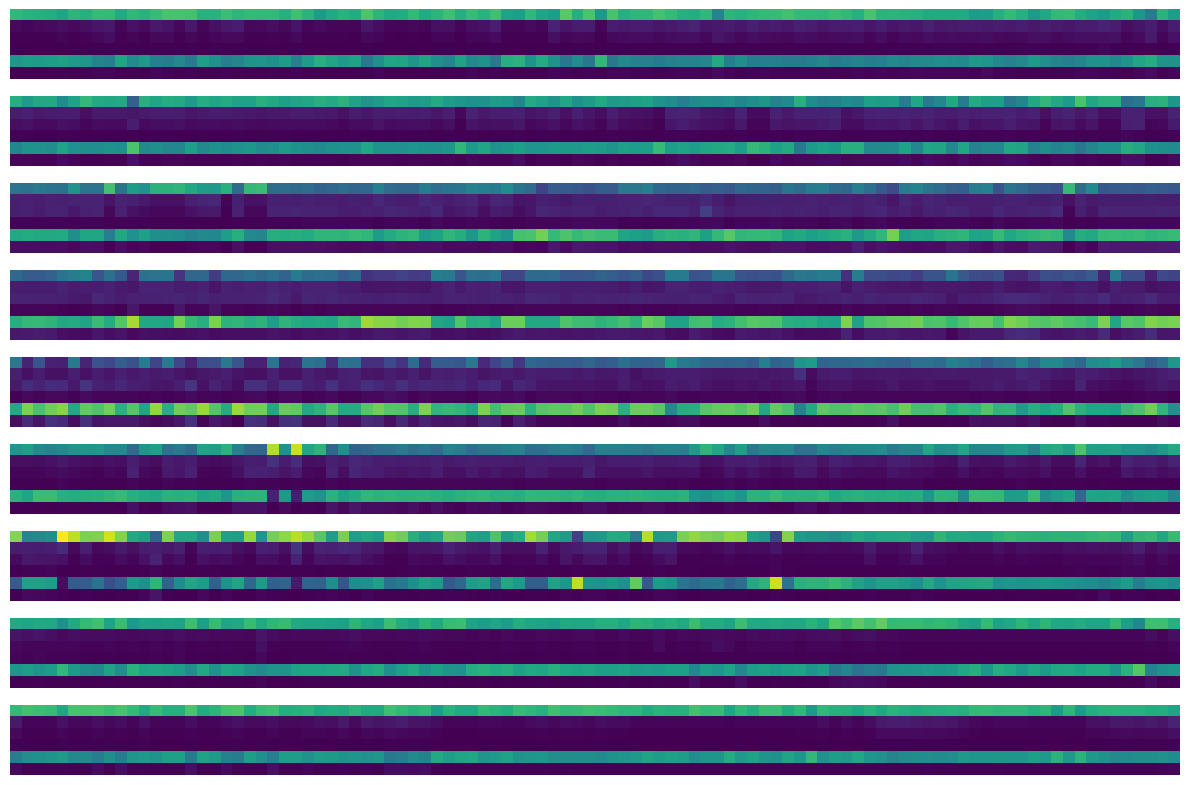

In [3]:
sheet_name = "iso modern cal"
# sheet_name = "SO Modern data"
df_calib = pd.read_excel(fnm_excel, sheet_name=sheet_name,skiprows=1).dropna()
df_calib["Age (Ma)"] = 0.0
df_calib["calibration"] = True

sst_name = "Sea Surface Temp"

if sheet_name == "SO Modern data":
    compound_names = df_calib.columns[4:10]
else:
    compound_names = df_calib.columns[2:8]

df_calib_compounds = df_calib[compound_names]
idx_calib = ~(df_calib_compounds==0).any(axis=1)
# idx_calib = (df_calib_compounds>0).any(axis=1)
df_calib_compounds = df_calib_compounds.loc[idx_calib]

n = len(df_calib)
print(n)
chunk_size = 100
n_rows = n//chunk_size
print(n,n_rows)

if n_rows > 1:
    X = df_calib_compounds.values.T

    fig, ax = plt.subplots(n_rows,1,sharex=True,sharey=True, figsize=(12,8))
    for i in range(n_rows):
        ax[i].imshow(X[:,i*chunk_size:(i+1)*chunk_size],vmin=X.min(),vmax=X.max())
        ax[i].axis("off")

    fig.tight_layout()
else:
    plt.matshow(df_calib_compounds.values.T)
    plt.axis("off")


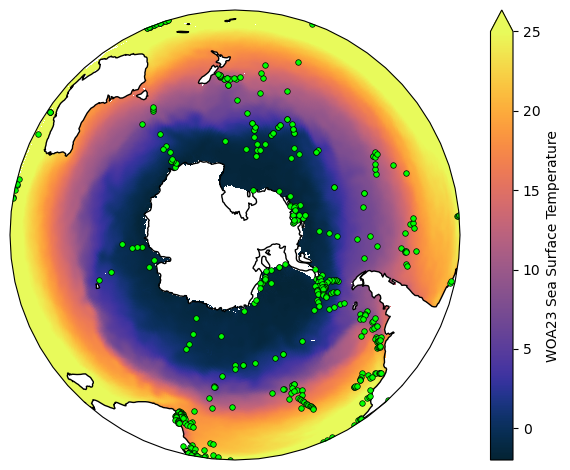

In [4]:
fnm = "../data/external/woa23_decav91C0_t00_04.nc"
ds = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True)
# ds.sel(depth=0)["t_an"].plot(vmin=-2,vmax=20)

proj = ccrs.Orthographic(central_longitude=180,central_latitude=-90)
data_proj = ccrs.Stereographic(central_longitude=-180,central_latitude=-90,true_scale_latitude=-70)
data_proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1,1,subplot_kw={"projection": proj})

ds

woa_lat = ds["lat"]
woa_t_an_zm = ds.sel(depth=0)["t_an"].mean("lon")
# print(woa_t_an_zm)

ax.coastlines()
im = ds.sel(depth=0)["t_an"].plot(ax=ax,vmin=-2,vmax=25,cmap=cmocean.cm.thermal,transform=data_proj,cbar_kwargs={"label": "WOA23 Sea Surface Temperature"})
# ax.set_global()

# # df_calib[df_calib["Core name"]=="ODP887"]["longitude"] = -148.268

ax.plot(df_calib["longitude"],df_calib["latitude"],ls='',marker='.',ms=8,color='lime',mew=0.5,mec='k',transform=ccrs.PlateCarree());
ax.set_title(None)
# plt.colo
# ax.set_extent()
fig.tight_layout()
fig.savefig("../reports/figures/SST_map_southern_ocean.png",dpi=300,bbox_inches='tight')

# Exploratory Data Analysis


The latitudinal temperature gradient can be approximates with a 2$^{\mathsf{nd}}$-order Legendre polynomial.
This will be useful later on, when we want to initialize the __unobserved__ sea surface temperature further back in time, because we do know the latitude for each GDGT sample.

     2
1.5 x - 0.5
[17.13785813 20.02371602]
SD = 2.86


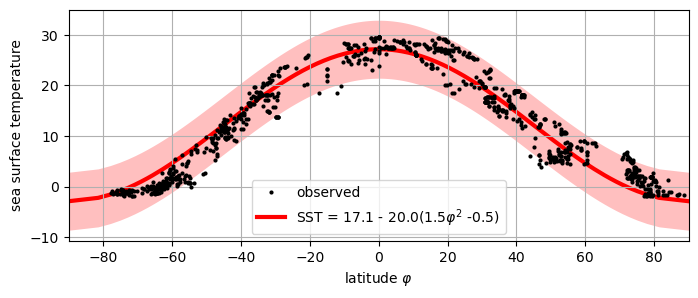

In [5]:
lat = np.sin(np.deg2rad(df_calib["latitude"]))

p2 = legendre(2)
print(p2)

def func_p2(x,a,b):
    return a-b*p2(x)

lat_bins = np.rad2deg(np.arcsin(np.linspace(-1, 1, 30)))
# print(lat_bins)

bin_means, lat_bins,_ = stats.binned_statistic(lat, df_calib[sst_name], statistic='median', bins=36, range=(-1,1))

# print(bin_means)

lat_ = [(lat_bins[i] + lat_bins[i+1])/2 for i in range(len(bin_means))] # find half-way points

# popt, pcov = curve_fit(func_p2,lat,df_calib[sst_name])
# popt, pcov = curve_fit(func_p2,np.sin(np.deg2rad(woa_lat[~np.isnan(woa_t_an_zm)])),woa_t_an_zm[~np.isnan(woa_t_an_zm)])
popt, pcov = curve_fit(func_p2,lat_,bin_means)
print(popt)

SD_lo = np.percentile(func_p2(lat,*popt)-df_calib[sst_name],3)
SD_hi = np.percentile(func_p2(lat,*popt)-df_calib[sst_name],97)
SD = SD_hi - SD_lo
SD = np.std(func_p2(lat,*popt)-df_calib[sst_name])
print(f"SD = {SD:.2f}")

fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(df_calib["latitude"],df_calib[sst_name],c='k',ls='',marker='.',mew=0,label='observed')
# ax.plot(np.rad2deg(np.arcsin(lat_)),bin_means,'go')
# ax.plot(woa_lat,woa_t_an_zm,'b-',label='WOA23')
x = np.linspace(-1,1,180) # more evenly spaced data points to plot the fitted curve
lat_label = r"$\varphi^2$"
eq = f"{popt[0]:.1f} - {popt[1]:.1f}(1.5{lat_label} -0.5)"
ax.plot(np.rad2deg(np.arcsin(x)),func_p2(x,*popt),'r-',lw=3,zorder=-5,label=f'SST = {eq}')
ax.fill_between(np.rad2deg(np.arcsin(x)),func_p2(x,*popt)-2*SD,func_p2(x,*popt)+2*SD,color='r',lw=0,alpha=0.25)
ax.set_xlim(-90,90)
ax.set_xlabel(r"latitude $\varphi$")
ax.set_ylabel("sea surface temperature")
ax.legend()
ax.grid()

p2_popt = [p for p in popt]
fig.savefig("../reports/figures/legendre_fit.png",dpi=300,bbox_inches='tight')

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Sea Surface Temp
0,0.630465,0.105530,0.027552,0.025425,0.544378,0.015013,-0.90
1,0.602791,0.044903,0.009265,0.013960,0.586971,0.017515,-1.70
2,0.595268,0.094107,0.020368,0.036891,0.583086,0.017515,-1.80
3,0.582371,0.116952,0.024940,0.031158,0.591827,0.020017,-1.60
4,0.545024,0.216240,0.056941,0.036891,0.604729,0.035029,-1.80
...,...,...,...,...,...,...,...
969,0.455936,0.409610,0.217437,0.066063,0.616952,0.114225,16.08
970,0.448115,0.421628,0.258574,0.056840,0.614575,0.117149,16.01
971,0.514280,0.496318,0.273766,0.066782,0.533389,0.099794,16.05
973,0.457558,0.515217,0.306453,0.095015,0.572550,0.144523,16.35


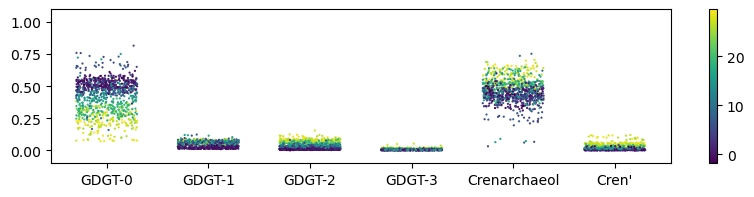

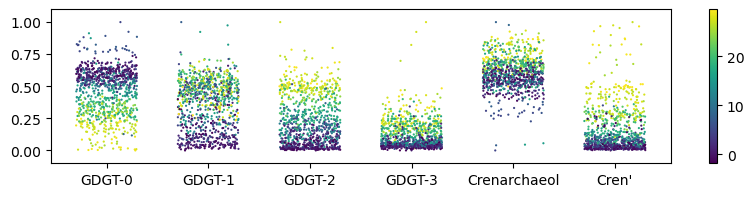

In [6]:
# adjusted from https://stackoverflow.com/a/60230746/1498309
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-0.3, 0.3, offsets.shape[0])
    dots.set_offsets(jittered_offsets)


df_calib_minmax = (df_calib_compounds - df_calib_compounds.min(axis=0))/(df_calib_compounds.max(axis=0) - df_calib_compounds.min(axis=0))
df_calib_minmax[sst_name] = df_calib[sst_name]
display(df_calib_minmax)

def plot_compounds(df,ylabel=None):
    fig, ax = plt.subplots(1,1,figsize=(10,2))
    for i, column in enumerate(compound_names):
        sst = df[sst_name]
        x = np.full((len(df), 1), i)
        y = df[column]
        dots = plt.scatter(x, y, s=10, c=sst, marker='.',alpha=1,lw=0)
        jitter_dots(dots)
    plt.xticks(range(len(compound_names)), compound_names)
    xmin, xmax = plt.xlim()
    ax.set_xlim(xmin - 0.3, xmax + 0.3)  # make some room to show the jittered dots
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.1,1.1)
    cbar = plt.colorbar()
    return fig, ax

fig, ax = plot_compounds(df_calib)
fig, ax = plot_compounds(df_calib_minmax)

## Different GDGT compounds have different SST dependencies

The GDGT compounds depend on sea surface temperature, but to different degrees. For example, GDGT-0 becomes smaller for warmer temperature, and Cren' increases non-linearly with temperature.

The GDGT compound proportions, $p$ all have to be $\in [0,1]$. We can achieve this by transforming a linear SST dependence into a sigmoid function, $\sigma(x) = 1/(1-e^{-x})$.

$$
p_i(T) = \frac{1}{1+e^{-[a + b\,T]}}
$$

Later on, as we will see, we want to estimate the *concentration* parameters for the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). The outputs of the Dirichlet distribution are the six proportions of the GDGT compounds. The concentration parameters can take values $\in [0,+\infty]$.

[ 0.21610033 -0.04550409]
[-3.23207551  0.0234351 ]
[-4.30572681  0.06896139]
[-5.77887609  0.05617254]
[-0.39777101  0.02154507]
[-5.83922774  0.10681658]


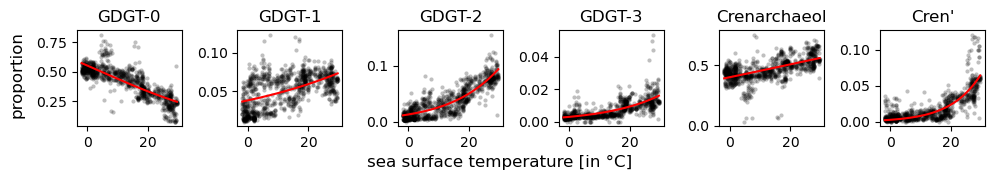

In [7]:
def func(x,a,b):
    y = a+b*x
    return expit(y)

# SST is our independent variable
x = df_calib[sst_name].values# + 273.15
xx = np.linspace(x.min(),x.max(),100) # for displaying the fitted curves
fig, ax = plt.subplots(1,6,figsize=(10,2),sharex=True)

for i,c in enumerate(compound_names):
    y = df_calib[c] # our dependent variable is the ith GDGT compound
    ax[i].plot(x,y,'k.',mew=0,alpha=0.25)
    popt, pcov = curve_fit(func,x,y)
    print(popt)
    ax[i].plot(xx,func(xx,*popt),'r-')
    ax[i].set_title(c)
fig.supxlabel("sea surface temperature [in °C]",y=0.125)
fig.supylabel("proportion",x=0.01,y=0.6)
fig.tight_layout()

# Southern Ocean Cenozoic data set

Now, let's load the Southern Ocean GDGT dataset into the mix to explore how sea surface temperatures have varied in the past.

(342, 6)


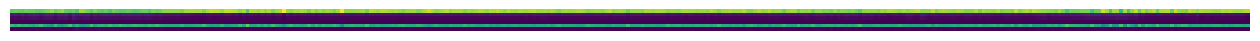

In [8]:
df_ceno = pd.read_excel(fnm_excel, sheet_name="Combined")

sst_name_ceno = "Sea Surface Temp"

df_ceno[sst_name_ceno] = np.nan
df_ceno["latitude"] = df_ceno["Latitude (approx paleo)"].values
df_ceno["calibration"] = False

col_map = {
    1302: "GDGT-0",
    1300: "GDGT-1",
    1298: "GDGT-2",
    1296: "GDGT-3",
    1292: "Crenarchaeol",
    "1292'": "Cren'",
    sst_name_ceno: sst_name
    }

df_ceno = df_ceno.rename(columns=col_map)

# display(df_ceno.loc[1304]) # this one looks odd; let's drop it.
df_ceno = df_ceno.drop(1304)
# filter and sort by age (age < 160ka BP)
age_max = 0.16
df_ceno = df_ceno[df_ceno["Age (Ma)"]<=age_max]
df_ceno_ = df_ceno.sort_values("Age (Ma)")
age = df_ceno_["Age (Ma)"]

compound_names = df_ceno_.columns[8:14]
df_ceno_compounds = df_ceno_[compound_names]

# plot proportions for data check
plt.matshow(df_ceno_compounds.values.T)
# plt.colorbar()
plt.axis("off")

print(df_ceno_compounds.values.shape)
idx_ceno = ~(df_ceno_compounds==0).any(axis=1)
# idx_ceno = (df_ceno_compounds>0).any(axis=1)
df_ceno_compounds = df_ceno_compounds.loc[idx_ceno]
# display(df_ceno_compounds)
# display(df_ceno_.loc[idx_ceno])

# Combine both data sets

In [9]:
columns = list(compound_names)+[sst_name,"Age (Ma)","calibration","latitude"]
display(df_ceno_[columns].loc[idx_ceno])
display(df_calib[columns].loc[idx_calib])

df_all = pd.concat([df_ceno_[columns].loc[idx_ceno],df_calib[columns].loc[idx_calib]],axis=0)
# df_all

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Sea Surface Temp,Age (Ma),calibration,latitude
991,0.484848,0.050635,0.017581,0.002988,0.437388,0.006560,NaN,0.000790,False,-50.567
1088,0.496196,0.059309,0.025377,0.003575,0.406032,0.009511,NaN,0.001650,False,-50.567
992,0.490190,0.047124,0.016838,0.003104,0.436036,0.006708,NaN,0.001960,False,-50.567
1089,0.483115,0.067558,0.028432,0.003140,0.405514,0.012241,NaN,0.002770,False,-50.567
993,0.500043,0.048536,0.017749,0.003268,0.423546,0.006858,NaN,0.003130,False,-50.567
...,...,...,...,...,...,...,...,...,...,...
1322,0.554875,0.034732,0.010577,0.002113,0.391483,0.006221,NaN,0.150330,False,-50.567
1323,0.546545,0.033114,0.010371,0.002011,0.402112,0.005847,NaN,0.151670,False,-50.567
1324,0.549005,0.037549,0.011429,0.002236,0.394623,0.005159,NaN,0.153010,False,-50.567
1325,0.565512,0.032427,0.009534,0.002161,0.383833,0.006533,NaN,0.154350,False,-50.567


,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Sea Surface Temp,Age (Ma),calibration,latitude
0,0.541400,0.021900,0.006800,0.002400,0.424800,0.002600,-0.90,0.0,True,-77.4700
1,0.520800,0.015000,0.004000,0.001800,0.455500,0.002900,-1.70,0.0,True,-74.1000
2,0.515200,0.020600,0.005700,0.003000,0.452700,0.002900,-1.80,0.0,True,-73.9400
3,0.505600,0.023200,0.006400,0.002700,0.459000,0.003200,-1.60,0.0,True,-72.5600
4,0.477800,0.034500,0.011300,0.003000,0.468300,0.005000,-1.80,0.0,True,-71.7500
...,...,...,...,...,...,...,...,...,...,...
969,0.411485,0.056507,0.035875,0.004527,0.477110,0.014496,16.08,0.0,True,-37.5013
970,0.405664,0.057875,0.042174,0.004044,0.475397,0.014846,16.01,0.0,True,-37.4910
971,0.454915,0.066376,0.044500,0.004564,0.416880,0.012765,16.05,0.0,True,-37.3560
973,0.412693,0.068527,0.049505,0.006042,0.445106,0.018128,16.35,0.0,True,-36.2195


# Bayesian Inference Model

In [10]:
N_SAMPLES = 50

observed = df_all[compound_names].values
sst = df_all[sst_name].values
lat = df_all['latitude'].values
xlat = np.sin(np.deg2rad(lat))

# N_TEST = 100
# idx_valid = np.random.choice(np.arange(len(sst)),N_TEST)
# idx_valid = np.linspace(0,len(sst)-len(sst)//N_TEST,N_TEST).astype(int) + np.random.randint(0,len(sst)//N_TEST,size=N_TEST)

# observed = observed[idx_valid]
# sst = sst[idx_valid]
# lat = lat[idx_valid]
# xlat = xlat[idx_valid]

print(observed.shape)
print(sst.shape)

sst0 = func_p2(xlat,*p2_popt)

n_compounds = observed.shape[1]
n_g_obs = observed.shape[0]

n_s_obs   = (~np.isnan(sst)).sum()
n_s_unobs = np.isnan(sst).sum()

print(n_g_obs, n_s_obs, n_s_unobs)
assert n_s_obs + n_s_unobs == n_g_obs

with pm.Model() as model:
    # Model coordinates (for convenience)
    model.add_coord("g_obs", np.arange(n_g_obs), mutable = True)
    model.add_coord("s_unobs", np.arange(n_s_unobs), mutable = True)
    model.add_coord("s_obs", np.arange(n_s_obs), mutable = True)
    model.add_coord("compounds", compound_names.values)

    # Observed data
    SST_data = pm.MutableData("SST_data", sst[~np.isnan(sst)], dims="s_obs")
    GDGT_data = pm.MutableData("GDGT_data", observed, dims=("g_obs","compounds"))
    
    # Priors for SST
    SST_σ = pm.HalfNormal("SST_σ", 1)#, dims="g_obs")
    SST_μ = pm.Normal("SST_μ", mu=sst0, sigma=2*SD, dims="g_obs")
    # Create a vector of flat variables for the unobserved and observed SSTs
    SST_unobs = pm.Normal("SST_unobserved", mu=SST_μ[np.isnan(sst)], sigma=SST_σ, shape=GDGT_data.shape[0]-SST_data.shape, dims="s_unobs")
    SST_obs   = pm.Normal("SST_observed", mu=SST_μ[~np.isnan(sst)], sigma=SST_σ, observed=SST_data, shape=SST_data.shape, dims="s_obs")
    # Create the symbolic value of SST, combining observed data and unobserved variables
    SSTs = pm.Deterministic("SST", pm.math.concatenate([SST_unobs, SST_obs]), dims="g_obs")
    print(SSTs.eval().min(),SSTs.eval().max())
    print(SSTs.eval().shape)
#     SST = pm.Normal("SST", mu=SST_μ, sigma=SST_σ, observed=sst, dims="total")

    # Priors for causal model (SST->GDGT) parameters
    # The exponentiated linear SST model: exp(a+b*SST) for the concentration parameters
    a = pm.Normal("a",  0.0, 1.0, dims="compounds")
    b = pm.Normal("b",  0.0, 0.1, dims="compounds")
    c = pm.Deterministic("c",pm.math.exp(a[None,:] + b[None,:]*SSTs[:,None]), dims=("g_obs","compounds"))
    # Dirichlet prior for GDGT
    GDGTs = pm.Dirichlet("GDGT", a=c, observed=GDGT_data, shape=GDGT_data.shape, dims=("g_obs","compounds"))
    print(GDGTs.eval().min(),GDGTs.eval().max())
    print(GDGTs.eval().shape)
    
    # Sample from prior
    idata = pm.sample_prior_predictive(samples=N_SAMPLES)  

(1291, 6)
(1291,)
1291 949 342
-18.802283131048842 39.5331208971475
(1291,)


Sampling: [GDGT, SST_observed, SST_unobserved, SST_μ, SST_σ, a, b]


0.0 0.9999904176244558
(1291, 6)


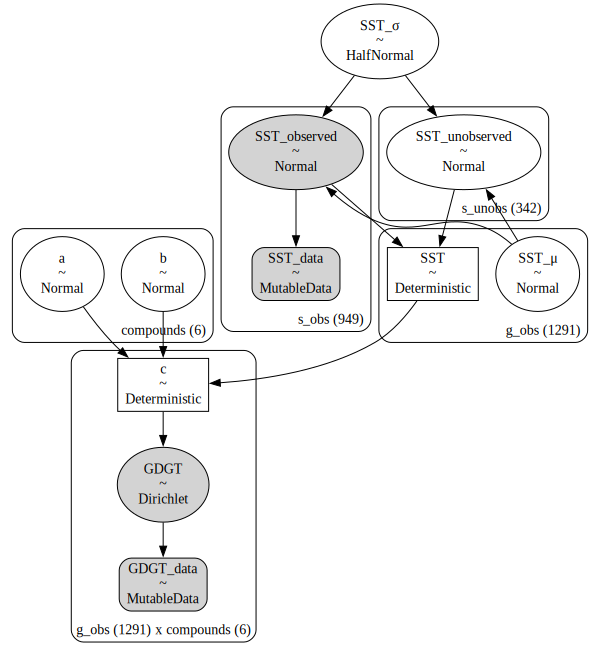

In [11]:
gv = pm.model_to_graphviz(model)
gv

In [12]:
gv.graph_attr.update(dpi=str(300))
gv.render(filename='../reports/figures/GDGT_proxy_system_model_graph',format='png');

In [13]:
model

         SST_σ ~ HalfNormal(0, 1)
         SST_μ ~ Normal(<constant>, 5.73)
SST_unobserved ~ Normal(f(SST_μ), SST_σ)
             a ~ Normal(0, 1)
             b ~ Normal(0, 0.1)
           SST ~ Deterministic(f(SST_observed, SST_unobserved))
             c ~ Deterministic(f(a, b, SST_observed, SST_unobserved))
  SST_observed ~ Normal(f(SST_μ), SST_σ)
          GDGT ~ Dirichlet(c)

In [14]:
observed[observed.sum(axis=1)==1].shape

(682, 6)

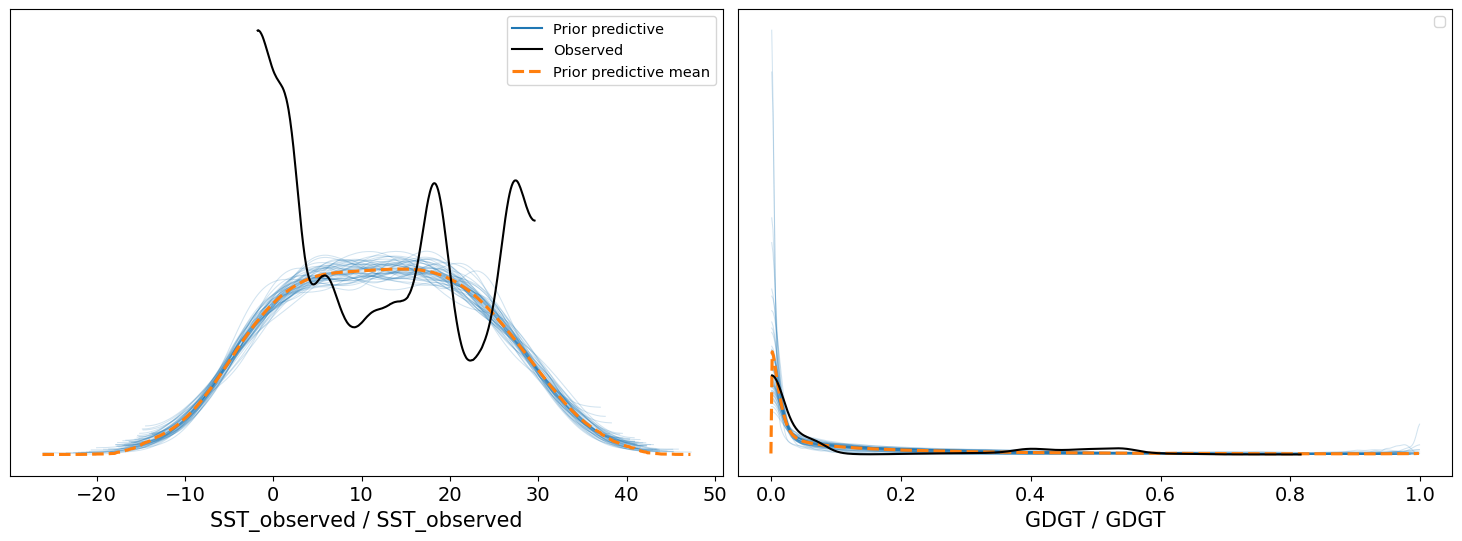

In [15]:
az.plot_ppc(idata,group="prior")
plt.tight_layout()

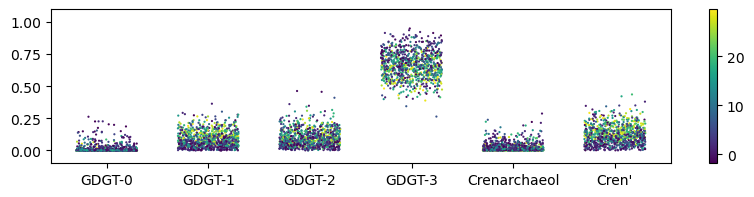

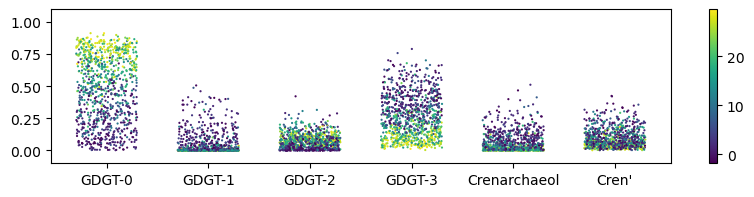

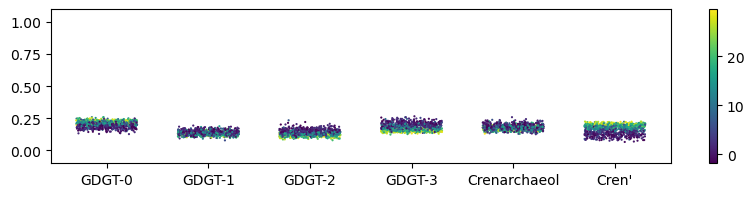

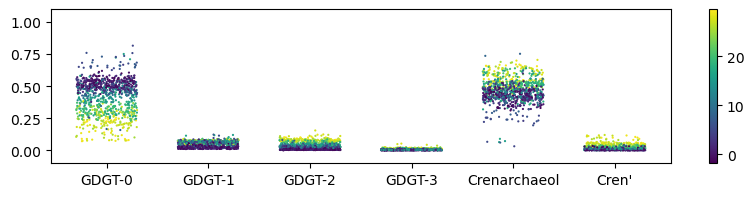

In [16]:
N = 2
for j,i in enumerate(np.random.choice(range(N_SAMPLES),N+1)):
    if j < N:
        data = idata.prior_predictive.stack(samples=("chain","draw")).isel(samples=i)
#     data = idata.prior_predictive.stack(samples=("chain","draw")).quantile(0.97,"samples")
    else:
        data = idata.prior_predictive.stack(samples=("chain","draw")).mean("samples")

    df_test = pd.DataFrame(data=data["GDGT"],columns=compound_names)
    df_test[sst_name] = sst
    _, _ = plot_compounds(df_test)
_, _ = plot_compounds(df_calib)

In [17]:
with model:
    idata.extend(pm.sample(1000, tune=2000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SST_σ, SST_μ, SST_unobserved, a, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1049 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


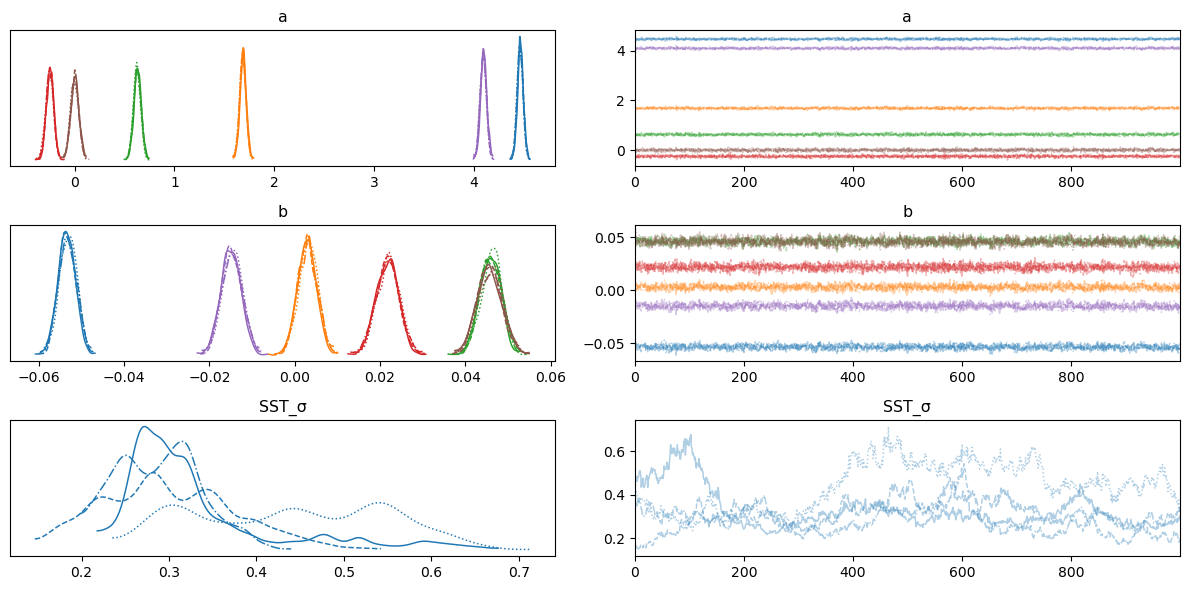

In [18]:
var_names = ["a","b"]+["SST_σ"]
ax = az.plot_trace(idata,var_names=var_names)
plt.tight_layout()

In [19]:
az.summary(idata,var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[GDGT-0],4.461,0.029,4.404,4.515,0.001,0.001,1589.0,2304.0,1.01
a[GDGT-1],1.684,0.032,1.627,1.748,0.001,0.001,1679.0,2369.0,1.01
a[GDGT-2],0.628,0.036,0.560,0.698,0.001,0.001,1777.0,2729.0,1.01
a[GDGT-3],-0.248,0.038,-0.317,-0.176,0.001,0.001,2736.0,3005.0,1.00
a[Crenarchaeol],4.092,0.032,4.034,4.153,0.001,0.001,1504.0,1911.0,1.01
a[Cren'],0.001,0.041,-0.075,0.077,0.001,0.001,2107.0,2654.0,1.00
b[GDGT-0],-0.053,0.002,-0.057,-0.050,0.000,0.000,1457.0,2222.0,1.00
b[GDGT-1],0.003,0.002,-0.001,0.007,0.000,0.000,1591.0,2361.0,1.00
b[GDGT-2],0.046,0.002,0.041,0.051,0.000,0.000,1617.0,2728.0,1.00
b[GDGT-3],0.022,0.003,0.017,0.027,0.000,0.000,2583.0,3035.0,1.00


In [20]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [GDGT, SST_observed]


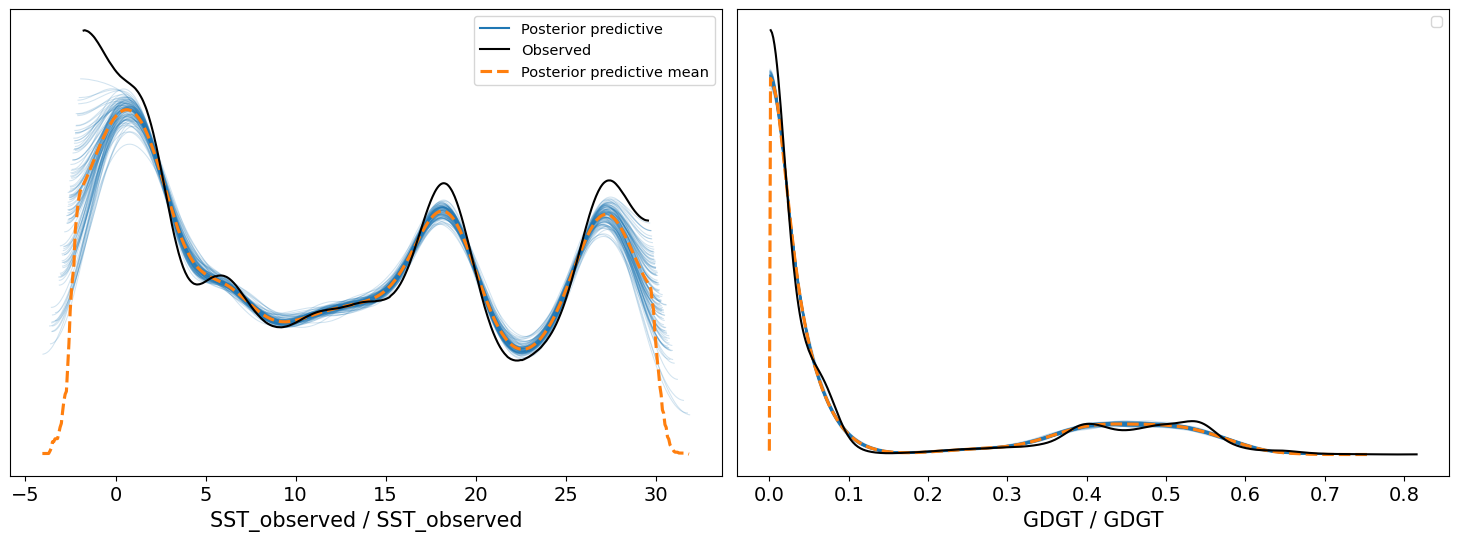

In [21]:
az.plot_ppc(idata, num_pp_samples=100)
plt.tight_layout()

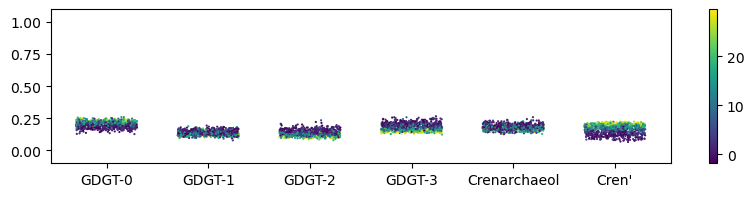

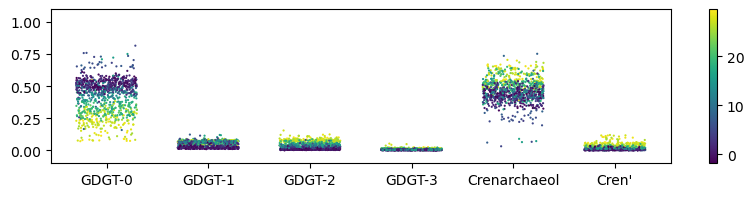

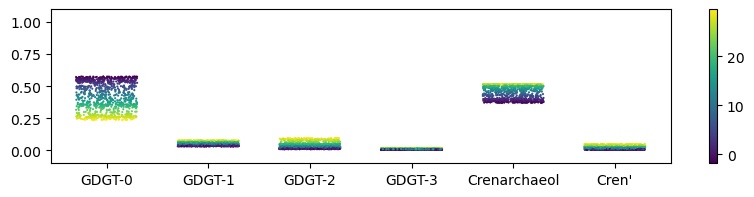

In [22]:
# data = idata.prior_predictive.stack(samples=("chain","draw")).isel(samples=10)
# data = idata.prior_predictive.stack(samples=("chain","draw")).quantile(0.03,"samples")
data = idata.prior_predictive.stack(samples=("chain","draw")).mean("samples")
data["GDGT"].values.T.shape
df_test = pd.DataFrame(data=data["GDGT"],columns=compound_names)
df_test[sst_name] = sst

# data_pp = idata.posterior_predictive.stack(samples=("chain","draw")).isel(samples=10)
# data_pp = idata.posterior_predictive.stack(samples=("chain","draw")).quantile(0.03,"samples")
data_pp = idata.posterior_predictive.stack(samples=("chain","draw")).mean("samples")
data_pp["GDGT"].values.T.shape
df_test_pp = pd.DataFrame(data=data_pp["GDGT"],columns=compound_names)
df_test_pp[sst_name] = sst

fig_prior, _ = plot_compounds(df_test)
fig_data, _ = plot_compounds(df_calib)
fig_posterior, _ = plot_compounds(df_test_pp)

In [23]:
fig_data.savefig("../reports/figures/GDGT_01data.png",dpi=150)
fig_prior.savefig("../reports/figures/GDGT_02prior.png",dpi=150)
fig_posterior.savefig("../reports/figures/GDGT_03prior.png",dpi=150)

In [24]:
# sst_pp = idata.posterior.stack(samples=("chain","draw")).mean("samples")["SST"]
sst_pp = idata.posterior_predictive.stack(samples=("chain","draw")).mean("samples")["SST"]
# sst_pp = idata.constant_data["SST"].squeeze(drop=True).values # for the constant case

gdgt_pp = idata.posterior_predictive.stack(samples=("chain","draw")).mean("samples")["GDGT"]
# gdgt_pp = idata.constant_data["GDGTs"].squeeze(drop=True)
df_test = pd.DataFrame(data=gdgt_pp,columns=compound_names)
df_test[sst_name] = sst_pp

def sample_df():
    data = idata.posterior_predictive.stack(samples=("chain","draw"))
#     print(data.dims["samples"])
    i = np.random.randint(data.dims["samples"])
    sst_pp = data.isel(samples=i)["SST"]
    gdgt_pp = data.isel(samples=i)["GDGT"]
    df_test = pd.DataFrame(data=gdgt_pp,columns=compound_names)
    df_test[sst_name] = sst_pp
    return df_test

df_test.sort_values(sst_name)

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Sea Surface Temp
75,0.594419,0.030117,0.009098,0.004003,0.357479,0.004885,-3.744755
1101,0.576028,0.032255,0.010477,0.004628,0.370979,0.005634,-1.805199
1146,0.575535,0.032512,0.010533,0.004594,0.371180,0.005645,-1.804322
1107,0.575629,0.032069,0.010455,0.004575,0.371520,0.005753,-1.800566
346,0.576110,0.032709,0.010434,0.004542,0.370581,0.005624,-1.799846
...,...,...,...,...,...,...,...
640,0.239076,0.078019,0.097751,0.019377,0.514740,0.051037,29.490113
637,0.238648,0.077712,0.096237,0.020152,0.516677,0.050574,29.491938
635,0.238790,0.078674,0.096282,0.019537,0.515053,0.051665,29.496376
636,0.238575,0.078523,0.096760,0.019660,0.514880,0.051601,29.497838


In [25]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

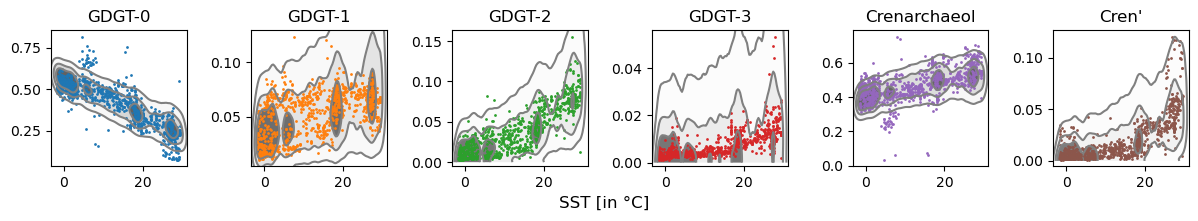

In [26]:
data_posterior_predictive = idata.posterior_predictive.stack(samples=("chain","draw"))
data_posterior = idata.posterior.stack(samples=("chain","draw"))
data_prior_predictive = idata.prior_predictive.stack(samples=("chain","draw"))

axes = df_all.plot(x=sst_name,y=compound_names,
              ls='', marker='.', ms=4, mew=0,
              subplots=True, layout=(1, -1), figsize=(12,2.4), sharex=True, legend=None)
ax_lims = []
for i,a in enumerate(axes.flat):
    ax_lims.append([a.get_xlim(),a.get_ylim()])
for i,a in enumerate(axes.flat):
    a.set_xlabel(None)      
    a.set_title(compound_names[i])
#     a.plot(df_test[sst_name],df_test[compound_names[i]],ls='-',marker='.',mew=0,color='k')    
    az.plot_kde(
        data_posterior_predictive["SST"][-n_s_obs:,:],
        data_posterior_predictive["GDGT"][-n_s_obs:,i,:],
        hdi_probs=[0.393, 0.865, 0.989],  # 1, 2 and 3 sigma contours
        contourf_kwargs={"cmap": "Greys"},
        ax=a
    )
    a_lims = ax_lims[i]
    a.set_xlim(*a_lims[0])
    a.set_ylim(*a_lims[1])

fig = a.get_figure()
fig.supxlabel("SST [in °C]",y=0.1)
fig.tight_layout()
fig.savefig("../reports/figures/GDGTs_with_posterior.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)

(342,)


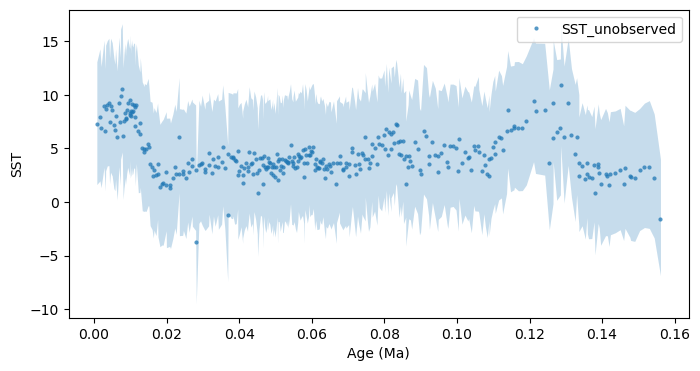

In [27]:
# Stack samples into a single dimension
stacked = az.extract(idata)

fig, ax = plt.subplots(1,1,figsize=(8,4))

unobserved = "SST_unobserved"
# mean
y = stacked[unobserved].mean(dim="sample")#*sst_sd+sst_mu
# 94% HDI
y_hdi_lo = stacked[unobserved].quantile(0.03,dim="sample")#*sst_sd+sst_mu
y_hdi_hi = stacked[unobserved].quantile(0.97,dim="sample")#*sst_sd+sst_mu
print(y.shape)

age = df_all[~df_all["calibration"]]["Age (Ma)"]

age_max = 0.16
this_age = age[age<age_max]
this_y = y[age.values<age_max]
this_y_hdi_lo = y_hdi_lo[age.values<age_max]
this_y_hdi_hi = y_hdi_hi[age.values<age_max]
l, = ax.plot(this_age,this_y,ls='',marker='.',mew=0,alpha=0.75,label=unobserved)
ax.fill_between(this_age,this_y_hdi_lo,this_y_hdi_hi,lw=0,color=l.get_color(),alpha=0.25)
ax.set_ylabel("SST")
#     ax.set_title(unobserved)
ax.set_xlabel("Age (Ma)")

# obs_ceno = df_ceno[compound_names].values
# g2_vals = (obs_ceno[:,2]+obs_ceno[:,3]+obs_ceno[:,5])/(obs_ceno[:,1]+obs_ceno[:,2]+obs_ceno[:,3]+obs_ceno[:,5])
# ax.plot(this_age,68.4*np.log10(g2_vals)+38.6,label="TEX86H")
ax.legend()
# ax.set_xscale("log")
# fig.savefig("mario-160ka_SouthernOceanSST.png",dpi=150,bbox_inches='tight', pad_inches = 0.01)

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc

Last updated: Wed Nov 08 2023

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.17.2

pymc: 5.9.1

cartopy   : 0.22.0
pandas    : 2.1.2
arviz     : 0.16.1
matplotlib: 3.8.1
numpy     : 1.24.4
pymc      : 5.9.1
scipy     : 1.11.3
cmocean   : 3.0.3
xarray    : 2023.10.1

Watermark: 2.4.3



# Regression model for TEX86

Based on [the TEX$_\textsf{86}$ Wikipedia article](https://en.wikipedia.org/wiki/TEX86#Calibrations).

In [78]:
print(observed.shape,sst.shape)
with pm.Model() as model_tex86:
    GDGTs = pm.ConstantData("GDGTs", observed)
    GDGT_2_ratio = (GDGTs[:,2]+GDGTs[:,3]+GDGTs[:,5])/(GDGTs[:,1]+GDGTs[:,2]+GDGTs[:,3]+GDGTs[:,5])
    print(GDGT_2_ratio.eval().shape)
    a = pm.Normal("a",30,10)
    b = pm.Normal("b",30,10)
    σ = pm.HalfNormal("σ",10)
    SST_TEX86H  = pm.Normal("SST_TEX86H",mu=a+b*pm.math.log(GDGT_2_ratio),sigma=σ,observed=sst)
    idata_tex86 = pm.sample_prior_predictive(samples=N_SAMPLES)  

/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in SST_TEX86H contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1B029AA40>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [SST_TEX86H_observed, SST_TEX86H_unobserved, a, b, σ]


(1291, 6) (1291,)
(1291,)


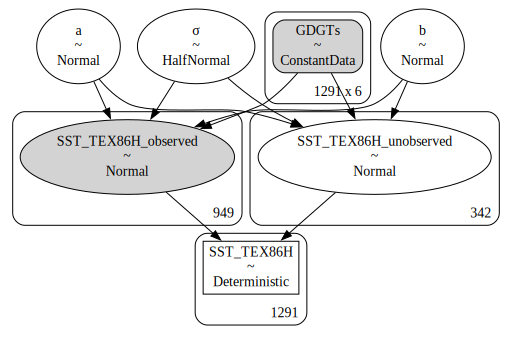

In [79]:
pm.model_to_graphviz(model_tex86)

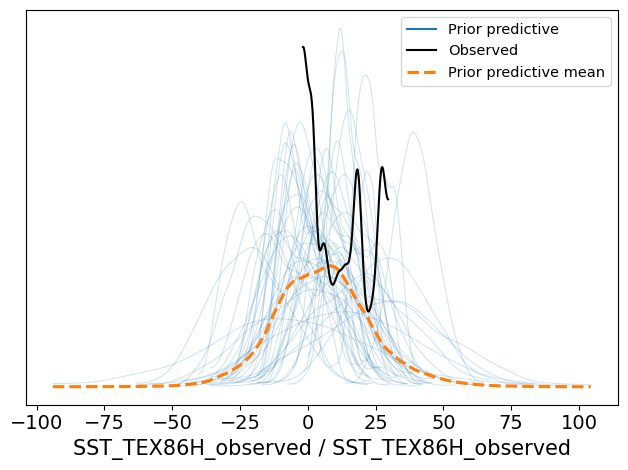

In [80]:
az.plot_ppc(idata_tex86,group="prior")
plt.tight_layout()

In [81]:
with model_tex86:
    idata_tex86.extend(pm.sample(1000, tune=2000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, σ, SST_TEX86H_unobserved]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 63 seconds.


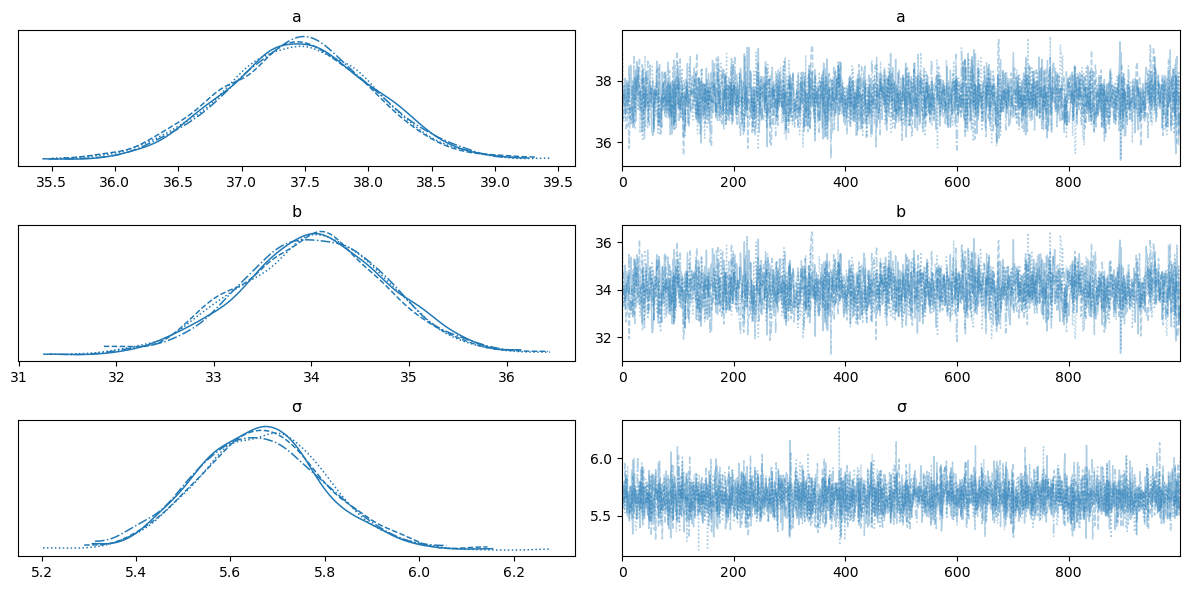

In [82]:
var_names = ["a","b"]+["σ"]
ax = az.plot_trace(idata_tex86,var_names=var_names)
plt.tight_layout()

In [83]:
az.summary(idata_tex86,var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,37.449,0.583,36.323,38.509,0.011,0.008,2674.0,2920.0,1.0
b,34.025,0.750,32.623,35.438,0.016,0.011,2172.0,2736.0,1.0
σ,5.664,0.134,5.423,5.929,0.002,0.001,3919.0,2434.0,1.0


In [84]:
with model_tex86:
    idata_tex86.extend(pm.sample_posterior_predictive(idata_tex86))

/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1B1C8C740>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [SST_TEX86H_observed]


<Axes: xlabel='SST_TEX86H_observed / SST_TEX86H_observed'>

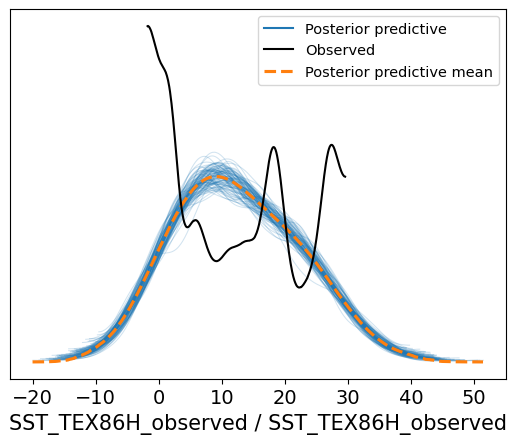

In [85]:
az.plot_ppc(idata_tex86, num_pp_samples=100)

(342,)


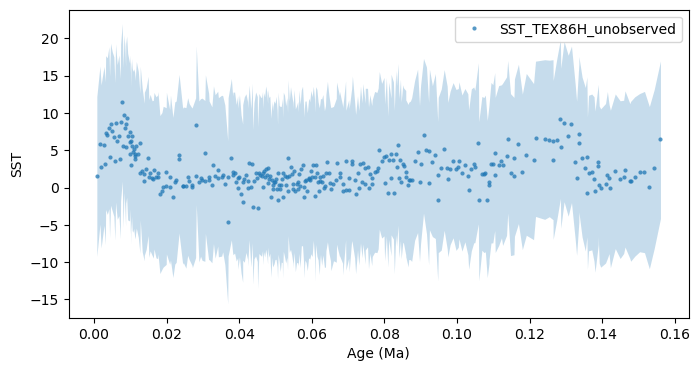

In [86]:
# Stack samples into a single dimension
stacked = az.extract(idata_tex86)

fig, ax = plt.subplots(1,1,figsize=(8,4))

unobserved = "SST_TEX86H_unobserved"
# mean
y = stacked[unobserved].mean(dim="sample")#*sst_sd+sst_mu
# 94% HDI
y_hdi_lo = stacked[unobserved].quantile(0.03,dim="sample")#*sst_sd+sst_mu
y_hdi_hi = stacked[unobserved].quantile(0.97,dim="sample")#*sst_sd+sst_mu
print(y.shape)

age = df_all[~df_all["calibration"]]["Age (Ma)"]

age_max = 0.16
this_age = age[age<age_max]
this_y = y[age.values<age_max]
this_y_hdi_lo = y_hdi_lo[age.values<age_max]
this_y_hdi_hi = y_hdi_hi[age.values<age_max]
l, = ax.plot(this_age,this_y,ls='',marker='.',mew=0,alpha=0.75,label=unobserved)
ax.fill_between(this_age,this_y_hdi_lo,this_y_hdi_hi,lw=0,color=l.get_color(),alpha=0.25)
ax.set_ylabel("SST")
ax.set_xlabel("Age (Ma)")

ax.legend();

# Regression model for Ring index

In [ ]:
with pm.Model() as model_ri:
    GDGTs = pm.ConstantData("GDGTs", obs)
    a = pm.Normal("a",sst_mu,5)
    b = pm.Normal("b",0,2)
    σ = pm.HalfNormal("σ",1)
    ri = pm.Deterministic("RI",GDGTs[:,1]+2*GDGTs[:,2]+3*GDGTs[:,3]+4*GDGTs[:,4]+4*GDGTs[:,5])
    SST_ri = pm.Normal("SST_ri",a+b*ri,σ,observed=sst)
    idata_ri = pm.sample_prior_predictive(samples=N_SAMPLES)  

In [ ]:
pm.model_to_graphviz(model_ri)

In [ ]:
az.plot_ppc(idata_ri,group="prior")
plt.tight_layout()

In [ ]:
with model_ri:
    idata_ri.extend(pm.sample(1000, tune=2000))

In [ ]:
var_names = ["a","b","σ"]
ax = az.plot_trace(idata_ri,var_names=var_names)
plt.tight_layout()

In [ ]:
az.summary(idata_ri,var_names=var_names)

In [ ]:
with model_ri:
    idata_ri.extend(pm.sample_posterior_predictive(idata_ri))

In [ ]:
az.plot_ppc(idata_ri, num_pp_samples=100)

In [ ]:
# Stack samples into a single dimension
stacked = az.extract(idata_ri)

fig, ax = plt.subplots(1,1,figsize=(8,4))

unobserved = "SST_ri_unobserved"
# mean
y = stacked[unobserved].mean(dim="sample")#*sst_sd+sst_mu
# 94% HDI
y_hdi_lo = stacked[unobserved].quantile(0.03,dim="sample")#*sst_sd+sst_mu
y_hdi_hi = stacked[unobserved].quantile(0.97,dim="sample")#*sst_sd+sst_mu
print(y.shape)

age = df_all[~df_all["calibration"]]["Age (Ma)"]

age_max = 0.16
this_age = age[age<age_max]
this_y = y[age.values<age_max]
this_y_hdi_lo = y_hdi_lo[age.values<age_max]
this_y_hdi_hi = y_hdi_hi[age.values<age_max]
l, = ax.plot(this_age,this_y,ls='',marker='.',mew=0,alpha=0.75,label=unobserved)
ax.fill_between(this_age,this_y_hdi_lo,this_y_hdi_hi,lw=0,color=l.get_color(),alpha=0.25)
ax.set_ylabel("SST")
ax.set_xlabel("Age (Ma)")

ax.legend();

# Comparison between SST→GDGT, TEX$_\textbf{86}$, and Ring index

Mean SD: 5.6764733132341725
(342,)
Mean SD: 3.1164310698417377
(342,)


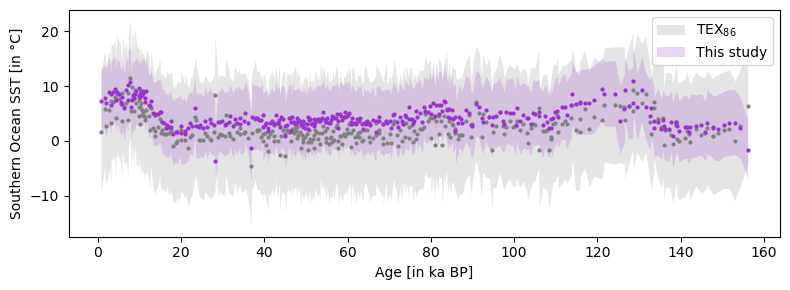

In [87]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

unobserved = ["SST_TEX86H_unobserved","SST_unobserved"]#,"SST_ri_unobserved"]
labels = [r"TEX$_\mathsf{86}$","This study"]
colors = ["grey","darkorchid"]
for i, this_idata in enumerate([idata_tex86,idata]):
    # Stack samples into a single dimension
    stacked = az.extract(this_idata)
    # mean
    y = stacked[unobserved[i]].mean(dim="sample")#*sst_sd+sst_mu
    # 94% HDI
    y_hdi_lo = stacked[unobserved[i]].quantile(0.03,dim="sample")#*sst_sd+sst_mu
    y_hdi_hi = stacked[unobserved[i]].quantile(0.97,dim="sample")#*sst_sd+sst_mu
    y_std = stacked[unobserved[i]].std(dim="sample")#*sst_sd+sst_mu
    print(f"Mean SD: {y_std.mean().values}")
    print(y.shape)

    age = df_all[~df_all["calibration"]]["Age (Ma)"]

    age_max = 0.16
    this_age = age[age<age_max]
    this_y = y[age.values<age_max]
    this_y_hdi_lo = y_hdi_lo[age.values<age_max]
    this_y_hdi_hi = y_hdi_hi[age.values<age_max]
    label = "_".join(unobserved[i].split("_")[:-1])
    l, = ax.plot(this_age*1e3,this_y,ls='',marker='.',c=colors[i],mew=0,alpha=1)
    ax.fill_between(this_age*1e3,this_y_hdi_lo,this_y_hdi_hi,lw=0,color=l.get_color(),alpha=0.2,label=labels[i])
    ax.set_ylabel("Southern Ocean SST [in °C]")
    ax.set_xlabel("Age [in ka BP]")
#     ax.set_ylim(-4,None)

ax.legend()
# ax.set_xscale("log")
fig.tight_layout()
fig.savefig("mario-160ka_SouthernOceanSST.png",dpi=150,bbox_inches='tight', pad_inches = 0.01)

# Out-of-sample predictions

In [106]:
# Doesn't work!!!

# other_observed = np.array([0.594122, 0.030387, 0.009224, 0.004048, 0.357293, 0.004925]).reshape((-1,6))
other_observed = df_test.iloc[:10][compound_names].values
SST_observed = df_test.iloc[:10][sst_name].values

# other_observed = df_ceno[compound_names].values
print(other_observed.shape,SST_observed.shape)
new_coords = {}
new_coords["compounds"] = model.coords["compounds"]
new_coords["s_unobs"] = []
new_coords["s_obs"] = np.arange(other_observed.shape[0])
new_coords["g_obs"] = np.arange(other_observed.shape[0])
# print(new_coords)
# new_coords["SST_unobserved_dim_0"] = new_coords["obs"]
with model:
    pm.set_data({'GDGT_data': other_observed, "SST_data": SST_observed}, coords=new_coords)
    
    y_test = pm.sample_posterior_predictive(idata)

Sampling: [GDGT, SST_observed, SST_unobserved, SST_μ]


(10, 6) (10,)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (1291,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1AD392B20>), MakeVector{dtype='int64'}.0, 11, [ 9.231930 ... .7755721 ], 5.728838817399327)
Toposort index: 5
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(1291,)), TensorType(float64, shape=())]
Inputs shapes: ['No shapes', (1,), (), (1291,), ()]
Inputs strides: ['No strides', (8,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0x1AD392B20, array([10]), array(11), 'not shown', array(5.72883882)]
Outputs clients: [['output'], [AdvancedSubtensor(SST_μ, [False Fal ... rue  True]), AdvancedSubtensor(SST_μ, [ True  Tr ... lse False])]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [89]:
df_test.sort_values(sst_name).iloc[0].values

array([ 0.5946058 ,  0.0304751 ,  0.00917471,  0.00402538,  0.35683723,
        0.00488178, -3.72493391])